## Sensitivity 



In [1]:
import itertools
from pathlib import Path
import copy

import numpy as np
import pandas as pd

from scripts.design.plot_design import plot_combined_measure_figure, plot_sensitivity
from scripts.design.utils import get_traject_probs, get_target_beta_grid, get_cost_traject_pf_combinations, \
    get_measures_df_with_dsn, get_dsn_point_pf_cost, get_least_expensive_combination_point, get_vr_eco_optimum_point
from scripts.postprocessing.database_access_functions import get_overview_of_runs, get_optimization_steps_for_run_id
from scripts.postprocessing.database_analytics import get_minimal_tc_step

from vrtool.orm.models import DikeTrajectInfo

In [ ]:
def show_results_sensitivity_analysis():
    # path = Path(r"C:\Users\hauth\OneDrive - Stichting Deltares\projects\VRTool\databases\38-1\automation")
    path = Path(r"C:\Users\hauth\OneDrive - Stichting Deltares\projects\VRTool\databases\41-1_test_automation\automation")

    # Input
    has_revetment = False
    LE = False
    t_design = 50
    # iterate through all the databases:

    # df results with DSN point, least_expensive point and vrm eco point
    df_results = pd.DataFrame(columns=['least_expensive_combination_cost', 'least_expensive_combination_pf',
                                       'dsn_point_cost', 'dsn_point_pf', 'vrm_eco_point_cost', 'vrm_eco_point_pf'])
    
    # retrieve coordinates of the 4 points
    cheapest_combination_cost, cheapest_combination_pf = [], []
    dsn_point_cost, dsn_point_pf = [], []
    vrm_eco_point_cost, vrm_eco_point_pf = [], []
    vrm_optimal_point_cost, vrm_optimal_point_pf = [], []  # point on the VR path fullfilling the target reliability.
    LE = []
    i = 0
    for db_path in path.glob("*.db"):
        print("Database: ", db_path)
        traject_probs = get_traject_probs(db_path)
        p_max = DikeTrajectInfo.get(DikeTrajectInfo.id == 1).p_max * 0.52
        traject_name = DikeTrajectInfo.get(DikeTrajectInfo.id == 1).traject_name
        optimization_steps = get_optimization_steps_for_run_id(db_path, 1)
        ind_2075 = np.where(np.array(traject_probs[0][0]) == 50)[0][0]  # find index where traject_probs[0][0] == 50
        pf_2075 = [traject_probs[i][1][ind_2075] for i in range(len(traject_probs))]
        cost_vrm = [optimization_steps[i]['total_lcc'] for i in range(len(traject_probs))]

        #### Get all combinations

        N_omega = [2., 4., 8., 16., 32.]
        N_LE = [5., 10., 20., 40., 50.]
        combination_df = get_target_beta_grid(N_omega, N_LE)
        # Put all the measures in a DataFrame for DSN
        measures_df_with_dsn = get_measures_df_with_dsn(LE, t_design)
        df_combinations_results = get_cost_traject_pf_combinations(combination_df, measures_df_with_dsn)
        cheapest_combination = get_least_expensive_combination_point(df_combinations_results, p_max)

        cheapest_combination_cost.append(cheapest_combination[0])
        cheapest_combination_pf.append(cheapest_combination[1])
        dsn_point_cost.append(get_dsn_point_pf_cost(db_path)[0])
        dsn_point_pf.append(get_dsn_point_pf_cost(db_path)[1])
        vrm_eco_point_cost.append(get_vr_eco_optimum_point(traject_probs, optimization_steps)[0])
        vrm_eco_point_pf.append(get_vr_eco_optimum_point(traject_probs, optimization_steps)[1])

        # Get distance between VR path and the least expensive combination
        # Point 1: VR lowest complying with the target reliability
        step_idx_pf_2075 = np.argwhere(np.array(pf_2075)<p_max*.52)[0][0]
        vrm_optimal_point_pf.append(pf_2075[step_idx_pf_2075])
        vrm_optimal_point_cost.append(cost_vrm[step_idx_pf_2075])

        # LE
        if i>50:
            LE.append(True)
        else:
            LE.append(False)

        i += 1


    df_results['least_expensive_combination_cost'] = cheapest_combination_cost
    df_results['least_expensive_combination_pf'] = cheapest_combination_pf
    df_results['dsn_point_cost'] = dsn_point_cost
    df_results['dsn_point_pf'] = dsn_point_pf
    df_results['vrm_eco_point_cost'] = vrm_eco_point_cost
    df_results['vrm_eco_point_pf'] = vrm_eco_point_pf
    df_results['vrm_optimal_point_cost'] = vrm_optimal_point_cost
    df_results['vrm_optimal_point_pf'] = vrm_optimal_point_pf
    df_results['LE'] = LE
    # save result in a csv
    df_results.to_csv(f'results_sensitivity_analysis_{traject_name}.csv')

    return df_results



In [9]:
df_results = show_results_sensitivity_analysis()


Database:  C:\Users\hauth\OneDrive - Stichting Deltares\projects\VRTool\databases\41-1_test_automation\automation\41-1_database_origineel_modified_50.db
Database:  C:\Users\hauth\OneDrive - Stichting Deltares\projects\VRTool\databases\41-1_test_automation\automation\41-1_database_origineel_modified_51.db
Database:  C:\Users\hauth\OneDrive - Stichting Deltares\projects\VRTool\databases\41-1_test_automation\automation\41-1_database_origineel_modified_52.db
Database:  C:\Users\hauth\OneDrive - Stichting Deltares\projects\VRTool\databases\41-1_test_automation\automation\41-1_database_origineel_modified_53.db
Database:  C:\Users\hauth\OneDrive - Stichting Deltares\projects\VRTool\databases\41-1_test_automation\automation\41-1_database_origineel_modified_54.db
Database:  C:\Users\hauth\OneDrive - Stichting Deltares\projects\VRTool\databases\41-1_test_automation\automation\41-1_database_origineel_modified_55.db
Database:  C:\Users\hauth\OneDrive - Stichting Deltares\projects\VRTool\databases\

Get the VR path of the base case (to show jjust for reference)

In [14]:
# Get the VR path from the initial database
db_path = Path(
    # r"C:\Users\hauth\OneDrive - Stichting Deltares\projects\VRTool\databases\38-1\automation\38-1_basis_modified_2.db"
    r"C:\Users\hauth\OneDrive - Stichting Deltares\projects\VRTool\databases\41-1_test_automation\automation\41-1_database_origineel_modified_50.db")
# Input
has_revetment = False
LE = False
t_design = 50
# _runs_overview = get_overview_of_runs(db_path)
##### Get VRM Optimization path
traject_probs = get_traject_probs(db_path)
p_max = DikeTrajectInfo.get(DikeTrajectInfo.id == 1).p_max * 0.52
optimization_steps = get_optimization_steps_for_run_id(db_path, 1)
considered_tc_step = get_minimal_tc_step(optimization_steps) - 1
ind_2075 = np.where(np.array(traject_probs[0][0]) == 50)[0][0]  # find index where traject_probs[0][0] == 50
pf_2075 = [traject_probs[i][1][ind_2075] for i in range(len(traject_probs))]
cost_vrm = [optimization_steps[i]['total_lcc'] for i in range(len(traject_probs))]

path_vrm = np.array([pf_2075, cost_vrm]).T


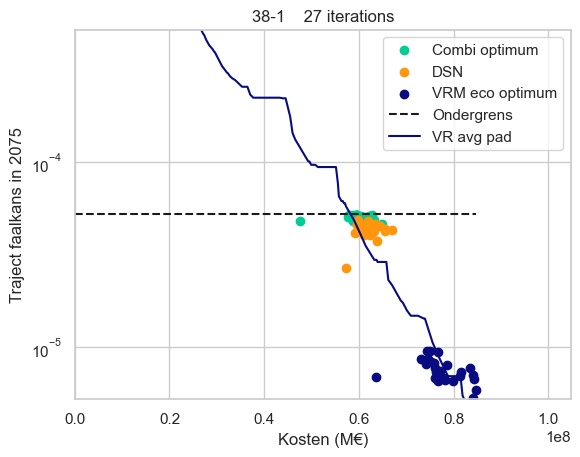

In [ ]:
import matplotlib.pyplot as plt
def plot_sensitivity2(df_sensitivity: pd.DataFrame, path_vrm, pmax: float):
    fig, ax = plt.subplots()
    from scripts.design.deltares_colors import colors

    ax.scatter(df_sensitivity["least_expensive_combination_cost"], df_sensitivity["least_expensive_combination_pf"], color=colors[4], label='Combi optimum')
    ax.scatter(df_sensitivity["dsn_point_cost"], df_sensitivity["dsn_point_pf"], color=colors[6], label='DSN')
    ax.scatter(df_sensitivity["vrm_eco_point_cost"], df_sensitivity["vrm_eco_point_pf"], color=colors[0], label='VRM eco optimum')
    # ax.scatter(df_sensitivity["vrm_optimal_point_cost"], df_sensitivity["vrm_optimal_point_pf"], color=colors[1], label='VRM target')
    ax.hlines(pmax, 0, df_sensitivity['vrm_eco_point_cost'].max(), colors='k', linestyles='dashed', label='Ondergrens')
    ax.plot(path_vrm[:, 1], path_vrm[:, 0], color=colors[0], label='VR avg pad')
    ax.set_xlim(left=0)
    ax.set_xlabel('Kosten (M€)')
    ax.set_ylabel('Traject faalkans in 2075')
    ax.set_yscale('log')
    ax.set_ylim(top=pmax * 10, bottom=pmax / 10)
    ax.legend()
    ax.set_title(f"38-1    {len(df_sensitivity)} iterations")

    plt.show()


pmax = DikeTrajectInfo.get(DikeTrajectInfo.id == 1).p_max * 0.52
plot_sensitivity2(df_results, path_vrm, pmax)


# Make a dsitribution:
#     - distance vr-dsn
#     - distance combi-dsn
    # - distance combi and closest vr point on the VR path

# make a comparison of all the soepel tables for all the runs.
# Make a script that Stefan or WJ can run on their horizon as well. Save the required results in a csv file that they will send out to me. Send as well instruction (which branch to checkout ...)


# Compare DSN vakspecifiek with VRM. Or compare VR with 

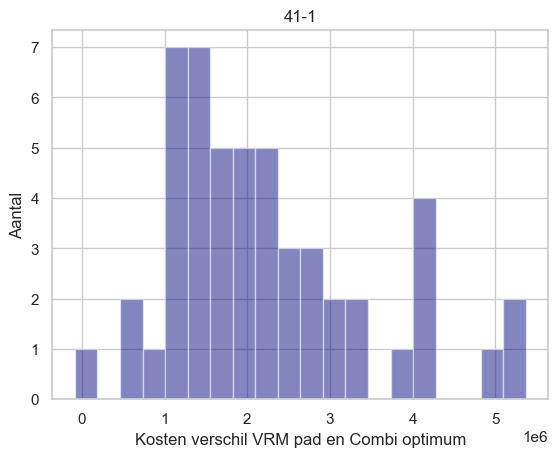

In [ ]:
def plot_distribution_distance_vr_path(df_sensitivity):
    fig, ax = plt.subplots()
    from scripts.design.deltares_colors import colors
    ax.hist(df_sensitivity['distance_vr_path'], bins=20, color=colors[0], alpha=0.5)
    ax.set_xlabel('Kosten verschil VRM pad en Combi optimum')
    ax.set_ylabel('Aantal')
    ax.set_title('41-1')

    plt.show()
plot_distribution_distance_vr_path(df_results)

# for stbi N=300 in base case. 

# same but diff VRM and combined values that vwere opimal in the origianl case. Compare the original green dot pairwise with the blue VRM of every run.